# House Prices Prediction

In this project, I aim to predict the sale price of houses based on their characteristics (size, year built, quality, location, etc.).
I use the Kaggle House Prices dataset, which is a well-known benchmark for supervised regression tasks.

My goal is to build and evaluate regression models to estimate the SalePrice.
I start with a baseline linear model and then compare it with more advanced methods such as Random Forests and Gradient Boosting (XGBoost).

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scp

# Preprocessing & pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Evaluation metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score
)

def evaluate_regression(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"----- {model_name} -----")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MedAE: {medae:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.4f}")
    
    return {"Model": model_name, "RMSE": rmse, "MAE": mae, "MedAE": medae, "MAPE": mape, "R2": r2}


### Data loading & Inspection

In [14]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

print(f"Shape of the train test :{df_train.shape}")
print(f"Shape of the test test :{df_test.shape}")
print(df_train.info())
print(f'Total of Null elements in the train set : {df_train.isna().sum().sum()}')
print(f'Total of Null elements in the test set : {df_test.isna().sum().sum()}')

print(df_train.head())

Shape of the train test :(1460, 81)
Shape of the test test :(1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-n

---

### Initial Data Observations  

From the first inspection of the dataset, a few important points emerge:  

- The training set contains **1460 rows and 81 columns**, while the test set has **1459 rows and 80 columns** (no `SalePrice` in the test set).  
- The dataset is a mix of **numeric** and **categorical** variables, meaning preprocessing will need to handle both types separately.  
- There are **7,829 missing values** across several features. Some columns (e.g., `Alley`, `PoolQC`, `Fence`, `MiscFeature`) contain mostly missing data and will be **dropped** from the analysis.  
- The target variable is **`SalePrice`**, which will be the focus of our regression models. Its distribution will need to be checked during EDA to see if a transformation is required.  

These observations already highlight that **data cleaning, imputation, and feature preprocessing** will be critical steps before building any predictive model.  

---

### Exploratory Data Analysis (EDA)

In this section, I perform an initial exploration of the dataset to better understand its structure, identify potential data quality issues, and examine relationships between key features and the target variable `SalePrice`.

The main goals are:
- Check the distribution and skewness of the target variable.
- Identify features with missing values.
- Visualize the most influential variables.

I start by exploring the target variable `SalePrice` to understand its distribution and skewness.  
Then, I check for missing values across the dataset to identify columns that require special treatment before modeling.

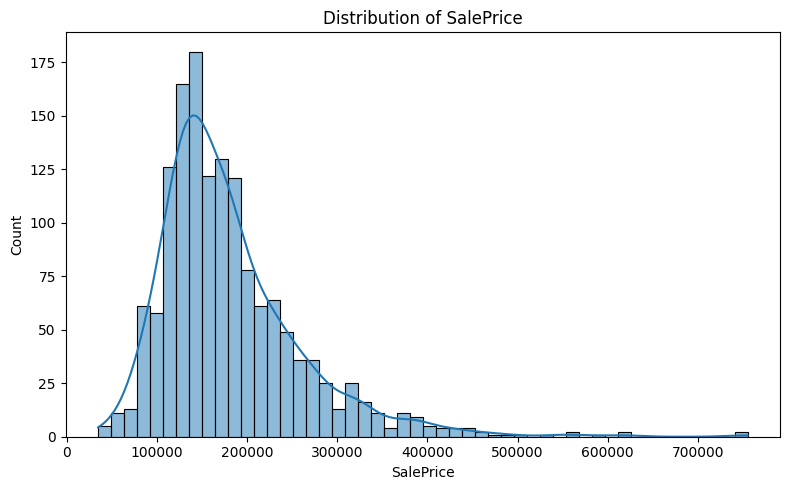

Skewness: 1.88
Kurtosis: 6.54


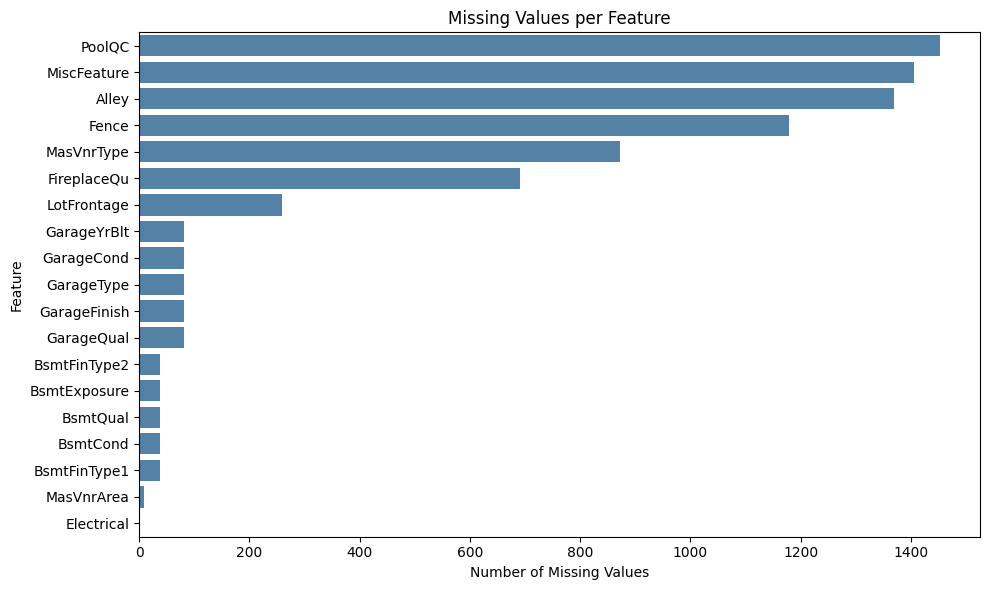

Top 10 features with missing values:
PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageYrBlt      81
GarageCond       81
GarageType       81
dtype: int64


In [15]:
# Target variable distribution (SalePrice)
plt.figure(figsize=(8,5))
sns.histplot(df_train["SalePrice"], bins=50, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../images/saleprice_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Skewness: {df_train['SalePrice'].skew():.2f}")
print(f"Kurtosis: {df_train['SalePrice'].kurt():.2f}")

# Missing values
missing = df_train.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]

plt.figure(figsize=(10,6))
sns.barplot(x=missing.values, y=missing.index, color="steelblue")
plt.title("Missing Values per Feature")
plt.xlabel("Number of Missing Values")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("../images/missing_values.png", dpi=300, bbox_inches="tight")
plt.show()

print("Top 10 features with missing values:")
print(missing.head(10))

- The target variable `SalePrice` is right-skewed (Skewness = 1.88, Kurtosis = 6.54).  
  → A log transformation will be applied to make it more normally distributed.  
- Some features (`PoolQC`, `MiscFeature`, `Alley`, `Fence`) contain over 80% missing values and will be dropped.  
- Other features with moderate missingness will be imputed (e.g., median for numerical values, mode or `"None"` for categorical).


---

#### Relationships Between Features and SalePrice

I now explore how key features relate to the target variable `SalePrice`.  
This helps identify which variables are most predictive and whether the relationships are linear or not.

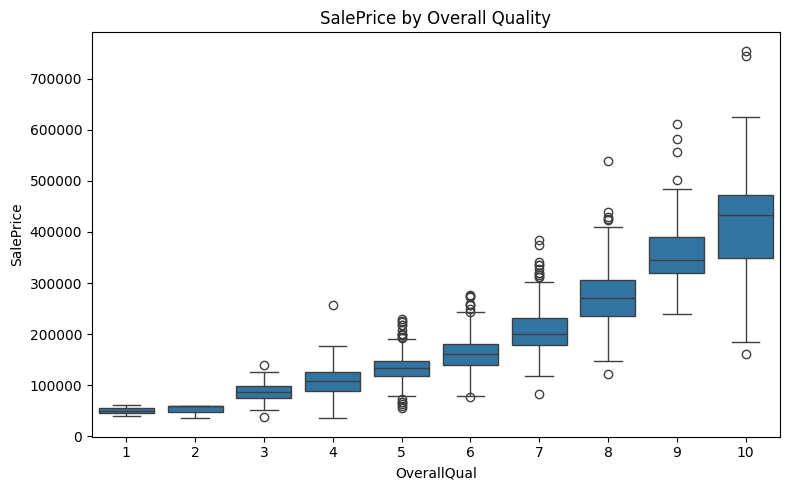

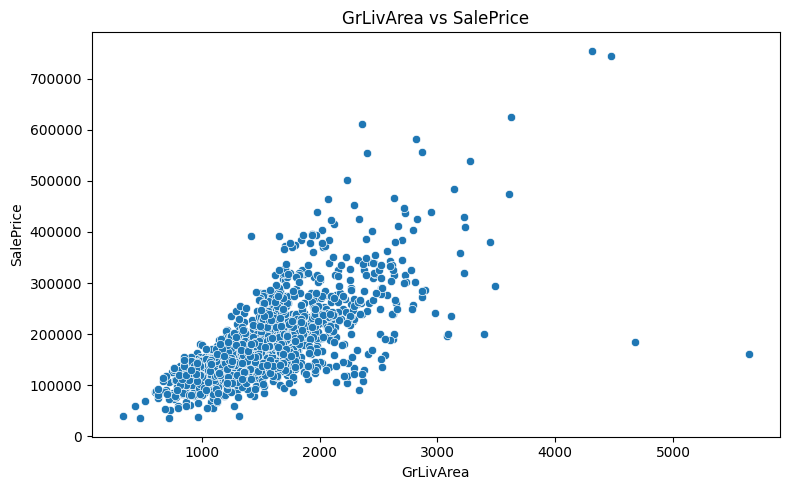

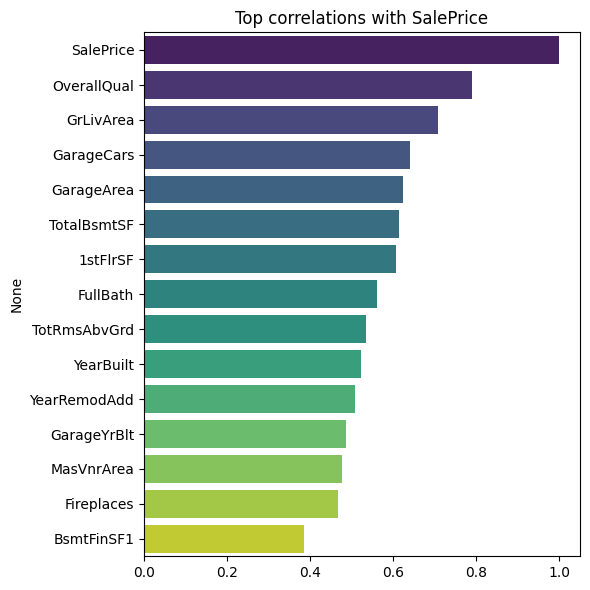

In [16]:
# OverallQual vs SalePrice
plt.figure(figsize=(8,5))
sns.boxplot(x="OverallQual", y="SalePrice", data=df_train)
plt.title("SalePrice by Overall Quality")
plt.tight_layout()
plt.savefig("../images/saleprice_overallqual.png", dpi=300, bbox_inches="tight")
plt.show()

# GrLivArea vs SalePrice
plt.figure(figsize=(8,5))
sns.scatterplot(x="GrLivArea", y="SalePrice", data=df_train)
plt.title("GrLivArea vs SalePrice")
plt.tight_layout()
plt.savefig("../images/saleprice_grlivarea.png", dpi=300, bbox_inches="tight")
plt.show()

# Correlation analysis
corr = df_train.corr(numeric_only=True)
top_corr = corr["SalePrice"].sort_values(ascending=False).head(15)

plt.figure(figsize=(6,6))
sns.barplot(x=top_corr.values, y=top_corr.index, hue=top_corr.index, palette="viridis", legend=False)
plt.title("Top correlations with SalePrice")
plt.tight_layout()
plt.savefig("../images/top_correlations.png", dpi=300, bbox_inches="tight")
plt.show()

The target variable `SalePrice` shows a strong skewness (1.88).  
To make the distribution more normal, I apply a log transformation using `np.log1p()`.  
This transformation helps models to capture the underlying relationships more effectively.

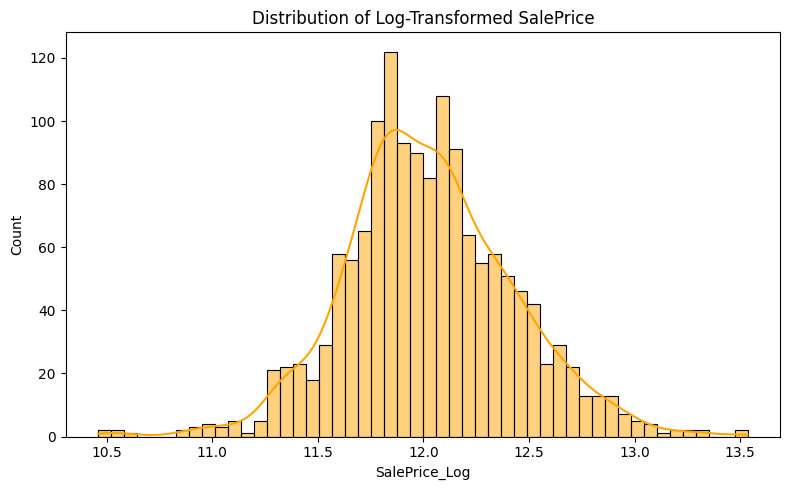

Original SalePrice mean: 180921.20
Transformed SalePrice mean: 12.02


In [17]:
df_train["SalePrice_Log"] = np.log1p(df_train["SalePrice"])

plt.figure(figsize=(8,5))
sns.histplot(df_train["SalePrice_Log"], bins=50, kde=True, color="orange")
plt.title("Distribution of Log-Transformed SalePrice")
plt.xlabel("SalePrice_Log")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../images/saleprice_log_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Original SalePrice mean: {df_train['SalePrice'].mean():.2f}")
print(f"Transformed SalePrice mean: {df_train['SalePrice_Log'].mean():.2f}")

---
### EDA observations

From this exploratory analysis, several key insights emerge:
- `SalePrice` is highly right-skewed so log transformation is justified.  
- A few features (`PoolQC`, `MiscFeature`, `Alley`, `Fence`) have too many missing values and will be dropped.  
- The most correlated features with `SalePrice` include `OverallQual`, `GrLivArea`, `GarageCars`, and `TotalBsmtSF`.  
- Some outliers are visible in `GrLivArea` and will be handled before modeling.  

These insights will directly guide the data preprocessing and feature engineering steps.

---

### Pre-Processing

In this section, I prepare the data for modeling.  
The preprocessing steps include:
- Removing features with too many missing values.  
- Handling remaining missing data.  
- Separating numerical and categorical variables.  
- Scaling and encoding features where necessary.  

Since the target variable has been log-transformed (`SalePrice_Log`), it will be used as `y` in the next steps.

In [18]:
# Drop columns with too many missing values
cols_to_drop = ["PoolQC", "MiscFeature", "Alley", "Fence"]
df_train = df_train.drop(columns=cols_to_drop)

# Separate target and features
y = df_train["SalePrice_Log"]
X = df_train.drop(columns=["SalePrice", "SalePrice_Log", "Id"])

print(f"Shape of features: {X.shape}")
print(f"Shape of target: {y.shape}")

# Identify numerical and categorical columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

print(f"Numerical features: {len(num_features)}")
print(f"Categorical features: {len(cat_features)}")

# Preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("num", make_pipeline(SimpleImputer(strategy="median"), StandardScaler()), num_features),
        ("cat", make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")), cat_features)
    ]
)

X_preprocessed = preprocess.fit_transform(X)
print(f"Preprocessed data shape: {X_preprocessed.shape}")

Shape of features: (1460, 75)
Shape of target: (1460,)
Numerical features: 36
Categorical features: 39
Preprocessed data shape: (1460, 274)


- Columns with excessive missingness (`PoolQC`, `MiscFeature`, `Alley`, `Fence`) were dropped.  
- Numerical features were imputed using the **median**, categorical ones using the **most frequent** value.  
- A preprocessing pipeline was created to handle both **scaling** (for numeric) and **encoding** (for categorical).  
- After applying the pipeline:
  - The dataset went from **75 original features** to **274 preprocessed columns**.  
  - This increase is due to **One-Hot Encoding**, which converts categorical variables into multiple binary columns (e.g. `Neighborhood_RL`, `Neighborhood_RM`, etc.).  
  - The resulting dataset is now **fully numerical** and ready for machine learning models.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape)

(1168, 75) (292, 75)


We split the dataset into a training set (80%) and a test set (20%) to evaluate model performance on unseen data.  
This ensures that the model is validated on data it has never seen during training.

---

## Linear Regression (Baseline Model)

We start with a **Linear Regression** model as a baseline to establish reference performance.  
The goal is to see how well a simple linear model captures relationships in the data before moving to more complex ones.

In [22]:
linreg_model = make_pipeline(
    preprocess,
    LinearRegression()
)

linreg_model.fit(X_train, y_train)
y_pred = linreg_model.predict(X_test)

linreg_results = evaluate_regression(y_test, y_pred, "Linear Regression")

----- Linear Regression -----
RMSE : 0.1290
MAE  : 0.0896
MedAE: 0.0602
MAPE : 0.75%
R²   : 0.9109


The Linear Regression model achieves strong initial results:  
- **RMSE = 0.1290** : on average, the prediction error is relatively low.  
- **MAE = 0.0896** and **MedAE = 0.0602** : the median and mean absolute deviations are small, indicating stable predictions.  
- **MAPE = 0.75%** : the model’s average percentage error is very low, sign of a good accuracy.  
- **R² = 0.91** : about 91% of the variance in SalePrice_Log is explained by the model.  

Overall, the Linear Regression performs surprisingly well as a baseline, suggesting that much of the price variation can be explained by linear relationships between the features and the target.  
Next, I will compare this baseline with more flexible models such as **Random Forest** and **XGBoost** to see if non-linear models can further reduce error.

---

## Random Forest Regressor

Next, we train a **Random Forest Regressor**, a non-linear ensemble model that often outperforms linear methods.  
We will compare its performance with the Linear Regression baseline using the same evaluation metrics.

In [39]:
rf_baseline = make_pipeline(
    preprocess,
    RandomForestRegressor(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

rf_baseline.fit(X_train, y_train)
y_pred_rf = rf_baseline.predict(X_test)

rf_results = evaluate_regression(y_test, y_pred_rf, "Random Forest (Baseline)")

----- Random Forest (Baseline) -----
RMSE : 0.1448
MAE  : 0.0982
MedAE: 0.0665
MAPE : 0.83%
R²   : 0.8877


In [40]:
results_df = pd.DataFrame([linreg_results, rf_results])
results_df

,Model,RMSE,MAE,MedAE,MAPE,R2
0,Linear Regression,0.128950,0.089642,0.060209,0.754711,0.910894
1,Random Forest (Baseline),0.144789,0.098210,0.066529,0.826192,0.887660


The Random Forest baseline underperforms compared to Linear Regression.  
I will now tune its hyperparameters with RandomizedSearchCV to see if performance can be improved.

In [41]:
param_range = {
    "randomforestregressor__n_estimators": scp.randint(100, 600),
    "randomforestregressor__max_depth": scp.randint(3, 20),
    "randomforestregressor__min_samples_split": scp.randint(2, 10),
    "randomforestregressor__min_samples_leaf": scp.randint(1, 5),
    "randomforestregressor__max_features": ["sqrt", "log2", None]
}

rf_model = make_pipeline(
    preprocess,
    RandomForestRegressor(random_state=RANDOM_STATE)
)

random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_range,
    n_iter=30,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)

# Best model and parameters
print(f"Best RMSE : {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

best_rf_model = random_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

rf_tuned_results = evaluate_regression(y_test, y_pred_best_rf, "Random Forest (Tuned)")

results_df = pd.DataFrame([linreg_results, rf_results, rf_tuned_results])
results_df

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RMSE : -0.14485446252217793
Best Parameters: {'randomforestregressor__max_depth': 18, 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 274}
----- Random Forest (Tuned) -----
RMSE : 0.1455
MAE  : 0.0976
MedAE: 0.0641
MAPE : 0.82%
R²   : 0.8865


,Model,RMSE,MAE,MedAE,MAPE,R2
0,Linear Regression,0.128950,0.089642,0.060209,0.754711,0.910894
1,Random Forest (Baseline),0.144789,0.098210,0.066529,0.826192,0.887660
2,Random Forest (Tuned),0.145519,0.097598,0.064093,0.821518,0.886524


The tuned Random Forest achieves similar performance to the baseline, 
confirming that the initial model was already close to optimal.  
This also reinforces that the log-transformation makes the target 
largely linear, which explains why the Linear Regression still performs best.

---

## XGBoost

We now train an **XGBoost Regressor** as our final model.  
This algorithm is a powerful gradient boosting method that often achieves top performance on tabular regression tasks.  
The following baseline configuration will serve as a starting point before hyperparameter tuning.

In [63]:
import xgboost as xgb
from xgboost import XGBRegressor

xgb_baseline = make_pipeline(
    preprocess,
    XGBRegressor(
        random_state=RANDOM_STATE,
        n_estimators=200,
        learning_rate=0.1,
        n_jobs=-1
    )
)
xgb_baseline.fit(X_train, y_train)
y_pred_xgb_baseline = xgb_baseline.predict(X_test)

xgb_baseline_results = evaluate_regression(y_test, y_pred_xgb_baseline, "XGBoost (Baseline)")

results_df = pd.concat([results_df, pd.DataFrame([xgb_baseline_results])], ignore_index=True)
results_df = results_df.drop_duplicates(subset="Model", keep="last").reset_index(drop=True)
results_df

----- XGBoost (Baseline) -----
RMSE : 0.1480
MAE  : 0.0961
MedAE: 0.0642
MAPE : 0.81%
R²   : 0.8826


,Model,RMSE,MAE,MedAE,MAPE,R2
0,Linear Regression,0.128950,0.089642,0.060209,0.754711,0.910894
1,Random Forest (Baseline),0.144789,0.098210,0.066529,0.826192,0.887660
2,Random Forest (Tuned),0.145519,0.097598,0.064093,0.821518,0.886524
3,XGBoost (Baseline),0.147986,0.096127,0.064247,0.810538,0.882644


The XGBoost baseline model shows slightly lower performance than the previous models, with an RMSE of 0.1480 and an R² of 0.8826.  
While still consistent with tree-based methods, its results indicate that the model could benefit from further tuning to reach optimal performance.

In [54]:
param_range = {
    "xgbregressor__n_estimators": scp.randint(200, 1200),
    "xgbregressor__max_depth": scp.randint(2, 10),
    "xgbregressor__learning_rate": scp.uniform(0.01, 0.25),
    "xgbregressor__subsample": scp.uniform(0.5, 0.5),
    "xgbregressor__colsample_bytree": scp.uniform(0.5, 0.5),
    "xgbregressor__gamma": scp.uniform(0, 0.5),
    "xgbregressor__reg_alpha": scp.uniform(0, 0.5),
    "xgbregressor__reg_lambda": scp.uniform(0.5, 1.0)
}

random_search_xgb = RandomizedSearchCV(
    xgb_baseline,
    param_distributions=param_range,
    n_iter=50,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
random_search_xgb.fit(X_train, y_train)

print(f"Best RMSE: {-random_search_xgb.best_score_:.4f}")
print(f"Best Parameters: {random_search_xgb.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RMSE: 0.1270
Best Parameters: {'xgbregressor__colsample_bytree': 0.7513395116144308, 'xgbregressor__gamma': 0.025739375624994676, 'xgbregressor__learning_rate': 0.07966161605915285, 'xgbregressor__max_depth': 2, 'xgbregressor__n_estimators': 584, 'xgbregressor__reg_alpha': 0.11978094533348621, 'xgbregressor__reg_lambda': 0.6448948720912231, 'xgbregressor__subsample': 0.7447263801387816}


After the wide exploration with RandomizedSearchCV, we now run a more focused **GridSearchCV**.  
The grid is built around the best parameters found previously, exploring only small variations.  
The goal is to refine the model hyperparameters and squeeze the last performance gains.

In [57]:
param_grid = {
    "xgbregressor__n_estimators": [565, 575, 600, 615],
    "xgbregressor__max_depth": [1, 2, 3],
    "xgbregressor__learning_rate": [0.07, 0.08, 0.09],
    "xgbregressor__subsample": [0.73, 0.74, 0.75, 0.76],
    "xgbregressor__colsample_bytree": [0.7, 0.75, 0.8],
    "xgbregressor__gamma": [0.02, 0.25, 0.3],
    "xgbregressor__reg_alpha": [0.11, 0.12, 0.13],
    "xgbregressor__reg_lambda": [0.6, 0.65, 0.7]
}

grid_search_xgb = GridSearchCV(
    xgb_baseline,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train, y_train)

print(f"Best RMSE : {-grid_search_xgb.best_score_:.4f}")
print(f"Best Parameters : {grid_search_xgb.best_params_}")

Fitting 5 folds for each of 11664 candidates, totalling 58320 fits
Best RMSE : 0.1245
Best Parameters : {'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__gamma': 0.02, 'xgbregressor__learning_rate': 0.07, 'xgbregressor__max_depth': 2, 'xgbregressor__n_estimators': 600, 'xgbregressor__reg_alpha': 0.11, 'xgbregressor__reg_lambda': 0.65, 'xgbregressor__subsample': 0.74}


I will train the final model with this best hyperparameters with early stopping, to avoid overfitting. 
To use early stopping, I have to break the pipeline to apply the prepreocessing and fit the model separately.

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=RANDOM_STATE)

X_tr_prep = preprocess.fit_transform(X_tr)
X_val_prep = preprocess.transform(X_val)
X_test_prep = preprocess.transform(X_test)

dtrain = xgb.DMatrix(X_tr_prep, label=y_tr)
dval = xgb.DMatrix(X_val_prep, label=y_val)
dtest = xgb.DMatrix(X_test_prep, label=y_test)

# Paramètres du modèle
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": RANDOM_STATE,
    "max_depth": 2,
    "learning_rate": 0.07,
    "subsample": 0.74,
    "colsample_bytree": 0.7,
    "gamma": 0.02,
    "reg_alpha": 0.11,
    "reg_lambda": 0.65
}

final_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dval, "validation")],
    early_stopping_rounds=50,
    verbose_eval=True
)
y_pred_final = final_xgb.predict(dtest)

xgb_final_results = evaluate_regression(y_test, y_pred_final, "XGBoost (Final)")
print(f"Best iteration: {final_xgb.best_iteration}")

results_df = pd.concat([results_df, pd.DataFrame([xgb_final_results])], ignore_index=True)

results_df

TypeError: XGBModel.fit() got an unexpected keyword argument 'callbacks'

### Final Results - Model Comparison

- **Linear Regression**: high Recall but extremely poor Precision, not usable in practice.  
- **Random Forest (tuned)**: strong balance, Precision and F1 much higher than Linear Regression.  
- **XGBoost (baseline)**: already very solid, outperforming Random Forest.  
- **XGBoost (grid)**: slight improvement from the baseline, thanks to fine-tuned hyperparameters.  
- **XGBoost (Final)**: best model overall, with a tuned threshold that delivers:
  - Precision ≈ 0.93  
  - F1 ≈ 0.86  
  - Excellent trade-off between catching frauds (Recall) and avoiding false alarms (Precision).  

This confirms that **XGBoost with tuned hyperparameters, early stopping, and an optimized threshold is the best model for fraud detection** on this dataset.

---


In [56]:
import joblib

joblib.dump(final_model, "../models/xgb_final_model.pkl")

['../models/xgb_final_model.pkl']

We save the full pipeline (`preprocess + XGBoost Final`) using **joblib**.  
This allows us to reload the trained model later without retraining, and use it directly for predictions.  

The model is saved in the `models/` folder as `xgb_final_model.pkl`.